# Apply custom classification algorithms on your imagery data

ArcGIS comes with a number of classification algorithms. All algorithms have limitations and some level of assumptions about the data they classify. Thus you may have datasets which do not conform to these assumptions or you may be a researcher building your own classification alrogithms. This sample shows how you can use the ArcGIS Python API to apply a custom classification that is not available as part of ArcGIS.

## Data used
This sample uses a [hyperspectral](https://en.wikipedia.org/wiki/Hyperspectral_imaging) imagery of Equador, captured by [hyperion](https://eo1.usgs.gov/sensors/hyperion) sensor onboard the [EO1]() satellite

|EO1 satellite | Hyperion sensor | Sample hyperspectal image cube |
|--|--|--|
|![EO1](http://earthobservatory.nasa.gov/Features/EO1/Images/eo_1_render.jpg)|![hyperion](https://eo1.usgs.gov/images/hyperionPhoto.jpg)|![cube](https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/HyperspectralCube.jpg/300px-HyperspectralCube.jpg)|

### Explore the dataset

In [2]:
# connect to the GIS
from arcgis.gis import GIS
gis = GIS("https://dev003246.esri.com/portal", "arcgis_python_api", "sharing.1")

In [3]:
# search for the Image layer
search_result = gis.content.search("Hyperion_clip", "Image Layer")
search_result

[<Item title:"Hyperion_clip" type:Image Service owner:arcgis_python_api>]

In [4]:
hyperion_item = search_result[0]
hyperion_item

<Item title:"Hyperion_clip" type:Image Service owner:arcgis_python_api>

In [5]:
hyperion_item.layers

[<ImageryLayer url:"https://Dev003246.esri.com/server/rest/services/Hyperion_clip/ImageServer">]

In [6]:
image_dataset = hyperion_item.layers[0]

#### Draw on a map

In [6]:
map1 = gis.map("Equador")
map1

In [7]:
map1.add_layer(image_dataset)

### Write your own viz scheme

In [8]:
def band_combinations(bands):
    return {
               "rasterFunction": "Stretch",
               "rasterFunctionArguments":{
                    "Raster":{
                        "rasterFunction": "ExtractBand",
                        "rasterFunctionArguments":{"BandIds": bands}
                    },
                    "StretchType": 6,
                    "DRA": True,
                    "Gamma": [1,1,1],
                    "UseGamma": True
                },
               "outputPixelType":"U8"
            }

In [9]:
map2 = gis.map("Equador")
map2

In [10]:
map2.add_layer(image_dataset, {"imageServiceParameters":{"renderingRule": band_combinations([153, 30, 21])}})

## Plot the spectra

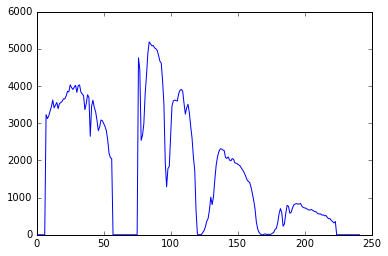

In [64]:
map3 = gis.map('Pifo', 12)
map3.add_layer(image_dataset, {"imageServiceParameters":{"renderingRule": band_combinations([153, 30, 21])}})
map3

In [65]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1)

In [66]:
from arcgis.features import FeatureSet, Feature
#from matplotlib import pyplot as plt

#fig, ax = plt.subplots(1,1)
spectra = []
def draw_spectra(m, g):
    # Construct a FeatureSet object from the clicked locaiton
    my_feature_set = FeatureSet([Feature(g)])
    
    # Query the server for pixel spectra at the clicked location
    p1 = my_feature_set.features[0].as_dict
    p1['geometryType'] = 'esriGeometryPoint'
    p1['f'] = 'json'
    
    server_response = gis._con.get(image_dataset.url + "/identify", p1)
    
    #analyze response from server
    spectrum_str = server_response['value']
    spectrum_list = [int(i) for i in spectrum_str.split(',')]
    
    spectra.append(spectrum_list)
    #fix, ax = plt.subplots()
    ax.plot(spectrum_list)
    plt.show()
    
# Set the callback function that performs analysis. The `do_analysis` function is called whenever user clicks on the map.
map3.on_click(draw_spectra)

In [72]:
len(spectra)

3

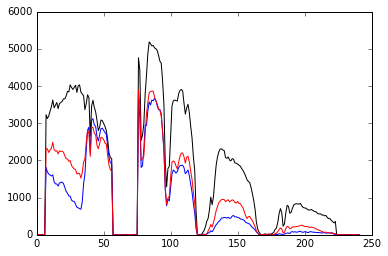

In [73]:
plt.plot(spectra[0], color='black')
plt.plot(spectra[1], color='blue')
plt.plot(spectra[2], 'r')
plt.show()

# Read raster data as numpy array

In [7]:
bbox = [image_dataset.properties.extent['xmin'],
        image_dataset.properties.extent['ymin'],
        image_dataset.properties.extent['xmax'],
        image_dataset.properties.extent['ymax']]

In [24]:
import numpy as np
np.arange(242)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [8]:
str(bbox)

'[789043.447037702, 9966818.854307624, 803164.9910233393, 9981216.689219667]'

In [34]:
img = gis._con.get(image_dataset.url + "/exportImage?f=image&bbox="+str(bbox[0])+","+str(bbox[1])+","+str(bbox[2])+","+str(bbox[3])+"&bandIds=55,80,100,126")

In [1]:
from scipy import ndimage

In [15]:
from matplotlib import pyplot as plt

In [35]:
img1 = ndimage.imread(img)
plt.imshow(img1)

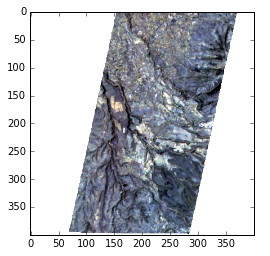

In [36]:
plt.show()

In [37]:
img1.shape

(400, 400, 4)